# Test 6 (Simulated Annealing)

Field: 8mT along the x axis

In [182]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore some messages from pandas
import pandas as pd
from tqdm import tqdm
import random

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

from auxiliary import classifyVertices, count_vertices_single, get_colloids_from_ctrj

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [183]:
# Some auxiliary functions

def getEnergy(col):
    B0 = 8*ureg.mT
    field = [1,0,0]*B0
    E = col.calculate_energy(B = field)
    return E.magnitude

def flipColloid(col, index):
    col2 = col.copy(deep = True)
    c = col2[index]
    c.colloid = -c.colloid
    c.direction = -c.direction
    col2[index] = c
    return col2

def flipColloids(col, amount):
    indices = np.random.randint(0,len(col)-1,amount)

    for index in indices:
        col = flipColloid(col,index)

def flipColloids_norandom(col, indices):

    for index in indices:
        col = flipColloid(col,index)
    
    
    return col

def isaccepted(dE,T):

    if dE < 0:
        return True
    else:
        r = np.random.rand()
        if r < np.exp(-dE/T):
            return True
        else:
            return False

In [3]:
# Definition of colloids

sp = ice.spins()

trapSep = 10*ureg.um
particleRadius = 5*ureg.um
L = 30*ureg.um
N = 10

# Create simulation objects
sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

particle = ice.particle(radius = particleRadius,
            susceptibility = 0.0576,
            diffusion = 0.125*ureg.um**2/ureg.s,
            temperature = 300*ureg.K,
            density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = trapSep,
            height = 4*ureg.pN*ureg.nm,
            stiffness = 1e-3*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap,
            height_spread = 0, 
            susceptibility_spread = 0.1,
            periodic = True)


col.randomize()
col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

# Simulated Annealing

In [4]:
np.random.seed(3)

In [ ]:
# Initial state

E0 = getEnergy(col)
col0 = col.copy(deep = True)
print(E0 / 1e6)

In [6]:
def simulation(colloid, niter = 100, saveall = False):
    dataPath = "../data/test6/"

    # Initialize stuff
    vertexSeries = np.zeros((niter,6))
    energies = np.zeros(niter)

    # Save initial state
    energies[0] = E0
    colloid.to_ctrj().to_csv(dataPath + "trj0.csv")

    # No sé por qué debo de calcular esto primero xd
    Eold = getEnergy(colloid)

    T = 300

    for k in range(1,niter):
        
        print(f"MC step {k}")
        newcolloid = colloid.copy(deep = True)
        newcolloid = flipColloids(newcolloid,3)

        Enew = getEnergy(newcolloid)
        dE = Enew - Eold

        # Accept or reject the change
        if isaccepted(dE,T):
            colloid = newcolloid.copy(deep = True)
            Eold = Enew
            energies[k] = Eold
        else:
            energies[k] = Eold
        
        # Store and save vertex counts
        if saveall:
            v = ice.vertices()
            v = v.colloids_to_vertices(col)
            vertices = classifyVertices(v.vertices).dropna()
            counts = count_vertices_single(vertices)
            vertexSeries[k,:] = counts["fraction"].to_list()
        
        currentFile = f"trj{k}.csv"
        colloid.to_ctrj().to_csv(dataPath + currentFile)
        
        T = 0.9*T
    
    # Make the dataframe that joins vertices and energy
    dataSeries = np.hstack((vertexSeries,energies.reshape(-1,1)))
    pdSeries = pd.DataFrame(data=dataSeries, columns=["I","II","III","IV","V","VI","energy"])

    if saveall:
        return colloid, pdSeries
    else:
        return colloid, energies


In [ ]:
final_state, data = simulation(col,10)

## Saving data

In [19]:
dataPath = "../data/test6/"
pd.DataFrame(data).to_csv(dataPath + "data.csv")

## Plotting energy

In [8]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(data)
ax.set_ylabel("Energy")
ax.set_xlabel("MC Steps")

## Plotting states

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
v = ice.vertices()
v = v.colloids_to_vertices(col)
col.display(ax)
v.display()
fig.savefig("initial.png")

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
v = ice.vertices()
v = v.colloids_to_vertices(col2)
final_state.display(ax)
v.display()
fig.savefig("final.png")

# Loading experiments and performing some analysis

In [247]:
final_trj = pd.read_csv("../data/test6/r2/trj9999.csv", index_col=0)
energies = pd.read_csv("../data/test6/r2/energies.csv", index_col=0)
final_trj.head()

,x,y,z,dx,dy,dz,cx,cy,cz
id,,,,,,,,,
0,15.0,0.0,0.0,-1.0,-0.0,-0.0,-5.0,-0.0,-0.0
1,45.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0
2,75.0,0.0,0.0,-1.0,-0.0,-0.0,-5.0,-0.0,-0.0
3,105.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0
4,135.0,0.0,0.0,-1.0,-0.0,-0.0,-5.0,-0.0,-0.0


In [248]:
col = get_colloids_from_ctrj(final_trj,particle,trap)
col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

v = ice.vertices()
v = v.colloids_to_vertices(col)
v.vertices.head()

100%|██████████| 200/200 [00:01<00:00, 152.05it/s]


,x,y,coordination,charge,dx,dy
vertex,,,,,,
0,0.0,150.0,3,-1,1.000000e+00,2.0
1,150.0,0.0,3,-3,6.123234e-17,1.0
2,0.0,240.0,3,-1,1.000000e+00,-2.0
3,120.0,270.0,4,4,0.000000e+00,0.0
4,270.0,270.0,4,0,-2.000000e+00,-2.0


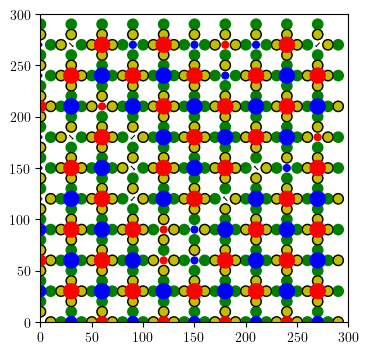

In [249]:
fig, ax = plt.subplots(figsize=(4,4))
col.display(ax)
v.display(ax)

In [250]:
energy = getEnergy(col)
print(energy)
energies.tail()

-206236.3044890945


,0
9995,-206236.304489
9996,-206236.304489
9997,-206236.304489
9998,-206236.304489
9999,-206236.304489


In [251]:
vertices = classifyVertices(v.vertices)
count_vertices_single(vertices)

,counts,fraction
type,,
I,28,0.345679
II,7,0.086420
IV,8,0.098765
V,5,0.061728
VI,33,0.407407


# Suffering flippling colloids

In [252]:
col2 = col.copy(deep=True) 

In [253]:
indices = [90,99,191,193,195,197,199,186,162,61,62,151,152,153,159,50,51,52,57,58,59,141,142,147,148,149,
           40,41,42,46,47,48,49,131,132,133,136,137,138,139,
           30,31,32,33,35,36,37,38,39,121,122,123,126,127,128,129,
           20,21,22,23,24,25,26,27,28,29,111,112,113,114,115,116,117,118,119,
           10,11,12,13,14,15,16,17,18,19,101,102,103,104,105,106,107,108,109,
           180,150,130,120,110,100,
           0,1,2,3,4,5,6,7,8,9
           ]



col2 = flipColloids_norandom(col2,indices)


In [254]:
v = ice.vertices()
v = v.colloids_to_vertices(col2)

100%|██████████| 200/200 [00:01<00:00, 141.13it/s]


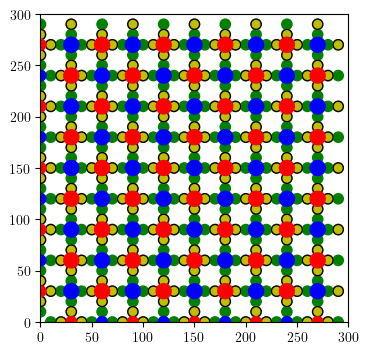

In [255]:
fig, ax = plt.subplots(figsize=(4,4))
col2.display(ax)
v.display(ax)

In [260]:
gs = col2.to_ctrj()

In [261]:
gs.to_csv("../data/gs90deg.csv")

In [258]:
E0 = getEnergy(col)
E1 = getEnergy(col2)
E1 - E0

-746.6044862293929

# Test stuff

Random experimental stuff that is not relevant for this test xd.

* Put all mcsteps in a multi index frame

Here I was trying the idea above but failed haha

In [ ]:
state1 = col.to_ctrj()
state2 = flipColloids(col,10).to_ctrj()

mcsteps = [k for k in range(2)]
particles = state1.index.get_level_values("id").values

index = pd.MultiIndex.from_product([mcsteps,particles], names=["mcstep","id"])
trj = pd.DataFrame(columns=state1.columns.to_list(), index=index)
trj